# Files and Imports

In [1]:
import numpy as np
import ast
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from pyomo.environ import units as u
from pyomo.environ import *
from scripts import run_bau_generation
from utils.powertech_helper import *
import platform
import seaborn as sns

if platform.system() =='Darwin':
    ROOT_PATH = '/Users/nkpanda97/Library/CloudStorage/OneDrive-DelftUniversityofTechnology/PhD_AllFolders/DatabaseCodes/powertech2025/'
    OUTPUT_PATH = ROOT_PATH+'outputs/'
elif platform.system() =='Linux':
    ROOT_PATH = '/home/npanda/DataBaseCodes/powertech2025/'
    OUTPUT_PATH = ROOT_PATH+'outputs/'
    raise ValueError('Platform not supported')

#Auto reload the imported modules
%load_ext autoreload
%autoreload 2
CS_CATEGORIES = ['residential','commercial','shared']
CS_PER_CATEGORY = ROOT_PATH + 'inputs/cs_per_category.pkl'
PATH_COST_DATA = ROOT_PATH+'inputs/day_ahead_price.pkl'
PATH_EMISSION_DATA = ROOT_PATH+'inputs/mef.pkl'
EV_DATA_RAW = pd.read_pickle(ROOT_PATH+'inputs/transactiondata_allstations_powerlog_cleaned_onlywithpowerlog.pkl')
EV_DATA_FOR_BAU_PROFILE_GENERATION = ROOT_PATH+'inputs/ev_data_for_bau_profile_generation_2023.pkl'

# Config parameters

In [2]:
DELTA_T = 1
KEY_DICT = {'Actual energy charged (kWh)': 'VOL',
            'Arrival_time': 'START',
            'Arrival_time_UTC_rounded':'START_UTC_rounded',
            'Departure_time_UTC_rounded':'STOP_UTC_rounded',
            'Departure_time': 'STOP',
            'Max charging power (kW)' : 'P_MAX',
            'Connector_id': 'Connector_id',
            # --- For optimization model ---
            'actual_energy_charged_value' : 'VOL',
            'arrival_time_integer' : 'START_int',
            'departure_time_integer' : 'STOP_int',
            'departure_time_integer_adjusted' : 'STOP_int_adj',
            'max_charging_power' :  'P_MAX',
            'duration_adj':'DUR_int_adj',
            'arrival_time': 'START_int',
            'departure_time': 'STOP_int',
            'energy_charged': 'VOL',
            'max_charging_power': 'P_MAX'
            }
BASE_PROFILES_TO_RUN = ['Cost','MEF','Dumb']
MAX_CONNECTION_TIME = 24  # in hours
TIME_HORIZON = 3*24
LAMBDA_VALUE = 1e-6
COST_DF = pd.read_pickle(PATH_COST_DATA)
MEF_DF = pd.read_pickle(PATH_EMISSION_DATA)

## Generate iter values

In [3]:
iter_date_range = pd.date_range(start='2023-01-02', end='2023-12-30', freq='D')
cs_categories = CS_CATEGORIES
cs_per_cat = pd.read_pickle(CS_PER_CATEGORY)
to_save_path = ROOT_PATH + 'inputs/iter_list_all_categories_2023.pkl'
ev_data = pd.read_pickle(EV_DATA_FOR_BAU_PROFILE_GENERATION)
bau_profiles = pd.read_pickle(ROOT_PATH+'outputs/base_profiles_complete.pkl')
try: 
    all_iter_list = pd.read_pickle(to_save_path)
    print('Iter list loaded')
except:
    print('Generating the iter list')
    all_iter_list =  generate_iter_list(ev_data=ev_data,
                                bau_profiles=bau_profiles,
                                iter_date_range=iter_date_range,
                                cs_categories=cs_categories,
                                cs_per_cat=cs_per_cat,
                                key_dict=KEY_DICT,
                                delta_t=DELTA_T,
                                time_horizon=TIME_HORIZON,
                                to_save_path=to_save_path,
                                day_ahead_df=COST_DF,
                                mef_df=MEF_DF)
                        

Iter list loaded


The following steps are done to quantify the flexibility for different flexibility products and various other parameters. 
### List of different parameters
1. PRODUCT_LIST = ['re_dispatch_down', 'capacity_limitation']
2. NOTICE_PERIOD = [ 'inf', 1, 6]
3. CHARGING_STRATEGIES = [True, False]
4. BASE_PROFILE = ['Dumb', 'Cost', 'MEF']
5. CATEGORIES = ['residential', 'commercial', 'shared']

### The step for a single iteration
1. Build the base optimization model: model =  create_base_flex_model(iter_data, delta_t, keywords, lambda_val)
2. Based on the choice of parameters, update the model: model =update_flex_model_parameters(model, bi_directional:bool,  flex_start:int, flex_end:int, base_profile_type:str, base_profile_dict:dict)
3. Build the objective function: model = model_product_builder(model, product_type, base_profile_type)
4. Fix the variables if there is a lead time: model = fix_p_variables(model:ConcreteModel,lead_time:int,ev_df:pd.DataFrame,base_profile_type:str,bi_directional:bool,f_start:int)
5. Solve the model: model = solve_model(model)

### Model Structure

<div style="display: flex;">

<div style="flex: 1; padding-right: 10px;">
    
| Model Parameters | Sets | Index |
|------------------|------|-------|
| n_cs             | Scalar | Scalar |
| vol_ev           | N    | [0,...,700] |
| t_a_ev           | N    | [0,...,700] |
| t_d_ev           | N    | [0,...,700] |
| p_max_ev         | N    | [0,...,700] |
| p_min_ev         | N    | [0,...,700] |
| base_profile     | T    | [0,...,71] |
| step_size        | Scalar | Scalar |
| flex_start       | Scalar | Scalar |
| flex_end         | Scalar | Scalar |
| lambda_          | Scalar | Scalar |
| cost             | T    | [0,...,71] |
| emission         | T    | [0,...,71] |

</div>

<div style="flex: 1; padding-left: 10px;">

| Model Variables  | Sets | Index |
|------------------|------|-------|
| p_ch_ev          | p_ch_ev_index | [(0, 0),...,(71, 700)] |
| soe_ev           | soe_ev_index | [(0, 0),...,(71, 700)] |
| aux_var          | Scalar | Scalar |
| p_agg            | T    | [0,...,71] |

| Model Constraints | Sets | Index |
|-------------------|------|-------|
| con_p_ch_limits   | con_p_ch_limits_index | [(0, 0),...,(71, 700)] |
| con_final_soe     | con_final_soe_index | [(0, 0),...,(71, 700)] |
| con_soe_update    | con_soe_update_index | [(0, 0),...,(71, 700)] |
| con_re_dispatch_down | T | [0,...,71] |
| con_p_agg         | T    | [0,...,71] |

</div>

</div>


In [4]:
import itertools

# Example usage
lead_time_list = ['inf', 1, 6]
bi_directional_list = [True, False]
f_start_list = list(range(24))
window_length_list = [1]
product_list = ['re_dispatch_down', 'capacity_limitation']
base_profile_list = ['Cost', 'MEF', 'Dumb']
data_index_list = list(np.arange(363))

combinations = generate_combinations(lead_time_list, bi_directional_list, f_start_list, 
                                      window_length_list, product_list, base_profile_list, data_index_list)

# Display the result
print(f"Total combinations: {len(combinations)}")
for combination in combinations[:5]:  # Print only the first 5 for brevity
    print(combination)


Total combinations: 313632
{'lead_time': 'inf', 'bi_directional': True, 'f_start': 0, 'f_end': 1, 'product': 're_dispatch_down', 'base_profile': 'Cost', 'data_index': 0}
{'lead_time': 'inf', 'bi_directional': True, 'f_start': 0, 'f_end': 1, 'product': 're_dispatch_down', 'base_profile': 'Cost', 'data_index': 1}
{'lead_time': 'inf', 'bi_directional': True, 'f_start': 0, 'f_end': 1, 'product': 're_dispatch_down', 'base_profile': 'Cost', 'data_index': 2}
{'lead_time': 'inf', 'bi_directional': True, 'f_start': 0, 'f_end': 1, 'product': 're_dispatch_down', 'base_profile': 'Cost', 'data_index': 3}
{'lead_time': 'inf', 'bi_directional': True, 'f_start': 0, 'f_end': 1, 'product': 're_dispatch_down', 'base_profile': 'Cost', 'data_index': 4}


# DATA Statistics

In [5]:
# print total transactions
print('Total transactions:', len(ev_data))
# print total transactions % category

transactions_per_cat = {cat_ : sum([len(all_iter_list[cat_][n]['individual_data']) for n in range(363)]) for cat_ in cs_categories}
transactions_per_cat
# Print as percentage of total transactions
total_transactions = sum(transactions_per_cat.values())
transactions_per_cat_percentage = {cat_ : 100*(transactions_per_cat[cat_]/total_transactions) for cat_ in cs_categories}
# Print in tabular form
print("\nTransactions per category (percentage):")
print("{:<15} {:<10}".format('Category', 'Percentage'))
for category, percentage in transactions_per_cat_percentage.items():
    print("{:<15} {:<10.2f}".format(category, percentage))


# total cs per category
np.concatenate([all_iter_list['residential'][1]['individual_data']['Connector_id'].unique() for n in range(363)])
# Calculate unique charging stations per category
unique_cs_per_cat = {cat_: len(np.unique(np.concatenate([all_iter_list[cat_][n]['individual_data']['Connector_id'].unique() for n in range(363)]))) for cat_ in cs_categories}

# Print unique charging stations per category
print("\nUnique charging stations per category:")
print("{:<15} {:<10}".format('Category', 'Unique CS'))
for category, unique_cs in unique_cs_per_cat.items():
    print("{:<15} {:<10}".format(category, unique_cs))



Total transactions: 256295

Transactions per category (percentage):
Category        Percentage
residential     57.66     
commercial      30.98     
shared          11.36     

Unique charging stations per category:
Category        Unique CS 
residential     313       
commercial      254       
shared          101       


# Aggregate Base Profile Analys

## Running BAU profile generation

In [6]:
try:
    bau_profiles = pd.read_pickle(ROOT_PATH+'outputs/base_profiles_complete.pkl')
    print('Base profiles already generated')
except:
    print('Generating base profiles')
    run_bau_generation.main(ROOT_PATH=ROOT_PATH)

Base profiles already generated


## Analyzing the BAU profile

         Category                            Profile  Idx_Max   Max_Val
0     residential  profile_Cost_bi_directional_False        2  4.772163
1     residential  profile_Cost_bi_directional_False        3  5.493781
2     residential  profile_Cost_bi_directional_False        3  3.263718
3     residential  profile_Cost_bi_directional_False        2  7.126390
4     residential  profile_Cost_bi_directional_False        3  6.464731
...           ...                                ...      ...       ...
3262       shared   profile_MEF_bi_directional_False        0  3.081000
3263       shared   profile_MEF_bi_directional_False        1  7.016176
3264       shared   profile_MEF_bi_directional_False       11  4.603261
3265       shared   profile_MEF_bi_directional_False        0  2.719179
3266       shared   profile_MEF_bi_directional_False        2  6.863403

[3267 rows x 4 columns]


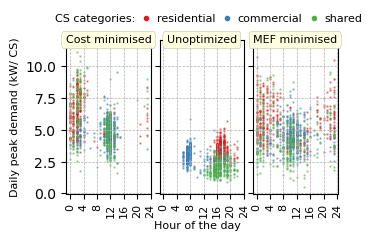

In [7]:
def plot_max_values(all_iter_list, categories, profiles, output_path, normalize=False):
    import matplotlib.pyplot as plt

    results = []

    for category in categories:
        for profile in profiles:
            day_profile_ = [all_iter_list[category][n]['aggeregate_profiles'][profile][24:48] for n in range(len(all_iter_list[category]))]
            n_cs = [len(all_iter_list[category][n]['individual_data']['Connector_id'].unique()) for n in range(len(all_iter_list[category]))]
            if normalize:
                max_val, idx_max = np.max(day_profile_, axis=1) / n_cs, np.argmax(day_profile_, axis=1)
            else:
                max_val, idx_max = np.max(day_profile_, axis=1), np.argmax(day_profile_, axis=1)
            for i in range(len(max_val)):
                results.append([category, profile, idx_max[i], max_val[i]])
   
    day_ahead_mean = np.array([all_iter_list['residential'][n]['signals']['day_ahead_price']['Day-ahead Price [EUR/kWh]'][24:48].to_list() for n in range(len(all_iter_list['residential']))]).mean(axis=0)

    mef_mean = np.array([all_iter_list['residential'][n]['signals']['mef']['MEF'][24:48].to_list() for n in range(len(all_iter_list['residential']))]).mean(axis=0)
    # Create a dataframe
    results_df = pd.DataFrame(results, columns=['Category', 'Profile', 'Idx_Max', 'Max_Val'])

    # Display the dataframe
    print(results_df)

    # Plot idx, max value for the three profiles in the same plot with different colors
    fig, ax = plt.subplots(1, 3, figsize=(3.5, 2), sharey=True, sharex=True)

    colors = ['#e41a1c', '#377eb8', '#4daf4a']
    titles = ['Cost minimised', 'Unoptimized', 'MEF minimised']
    for i, profile in enumerate(profiles):
        
        
        for j, category in enumerate(categories):
            subset = results_df[(results_df['Category'] == category) & (results_df['Profile'] == profile)]
            ax[i].scatter(subset['Idx_Max'], subset['Max_Val'], label=category, color=colors[j], s=0.5, alpha=0.5)
        
        # if i == 0:
        #     # if i = 0, or i =2 plot the day_ahead_mean or mef_mean in secondary axis
        #     ax[i].twinx().step(np.arange(24), day_ahead_mean, color='black', label='Day-ahead price [EUR/kWh]', linewidth=1)
        # elif i == 2:
        #     ax[i].twinx().step(np.arange(24), mef_mean, color='black', label='MEF [gCO2eq/kWh]', linewidth=1)


        ax[i].text(0.5, 1, titles[i],
                    horizontalalignment='center', 
                    verticalalignment='center', 
                    transform=ax[i].transAxes, 
                    fontsize=8, 
                    weight='normal',  # Make the text non-bold
                    bbox=dict(facecolor='lightyellow', boxstyle='round,pad=0.35', linewidth=0.1))  # Add text box with light shading and thin border

        # ax[i].set_title(titles[i], fontsize=8, fontweight='bold')
        ax[i].set_xlabel('')
        if i == 0:
            if normalize:
                ax[i].set_ylabel('Daily peak demand (kW/ CS)', fontsize=8)
            else:
                ax[i].set_ylabel('Power (kW)', fontsize=8)
        ax[i].set_xticks(np.arange(0, 28, 4))
        ax[i].set_xticklabels(np.arange(0, 28, 4), fontsize=8, rotation=90)
        # grid  
        ax[i].grid(axis='both', linestyle='--', linewidth=0.5)

    # Create a custom legend with the same color but marker size 3
    header = plt.Line2D([0], [0], color='black',linewidth=0, marker='', linestyle='', markersize=3)
    custom_lines = [plt.Line2D([0], [0], color=colors[i], marker='o', linestyle='', markersize=3) for i in range(len(categories))]
    fig.legend([header]+custom_lines, ['CS categories:']+categories, loc='upper center', 
               fontsize=8, ncol=len(categories)+1, bbox_to_anchor=(0.5, 1.06), frameon=False,
               columnspacing=0, handletextpad=0)
    # fig.text(0.5, 1.08, 'Yearly Peak Power Distribution by Hour', ha='center', va='center', fontsize=8, fontweight='bold', color='blue')

    # Fig x label
    fig.text(0.5, -0.05, 'Hour of the day', ha='center', va='center', fontsize=8)

    # Adjust horizontal spacing
    fig.subplots_adjust(wspace=.1)
    plt.show()
    fig.savefig(output_path+'/results/' + 'base_profiles_idx_max_values.pdf', bbox_inches='tight')

    # Save the results dataframe to a CSV file
    results_df.to_csv(output_path+'/outputs' + 'base_profiles_idx_max_values.csv', index=False)

# Example usage
plot_max_values(all_iter_list, CS_CATEGORIES, ['profile_Cost_bi_directional_False',"profile_Dumb_bi_directional_False","profile_MEF_bi_directional_False"], ROOT_PATH, normalize=True)


# Flexibility Analysis
## Analysis of different window length

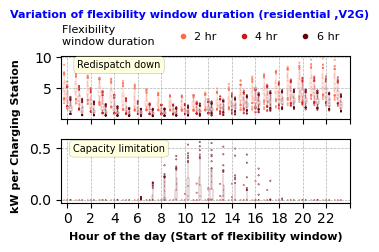

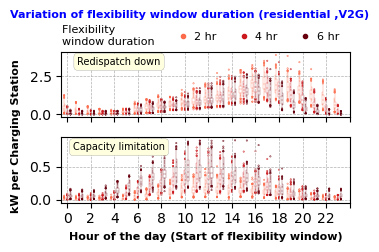

In [8]:
def generate_flexibility_plots_window(
    all_flex_res_path, 
    product_list, 
    color_palette, 
    bi_directional=True, 
    normalize=True, 
    output_path=None
):
    # Load and preprocess data
    all_flex_res = pd.read_parquet(all_flex_res_path)
    all_flex_res.index = all_flex_res['Index'].apply(lambda x: str(x))
    result_dist = {}

    # Helper function to create boxenplot
    def create_boxenplot(df, color_palette, ax):
        unique_groups = sorted(df['window_duration'].unique())
        custom_palette = dict(zip(unique_groups, color_palette))
        sns.boxenplot(
            data=df,
            x='Hour_of_day',
            y='Values',
            hue='window_duration',
            ax=ax,
            gap=0.3,
            palette=custom_palette,
            linewidth=0.2,
            width=0.8,
            fill=False,
            flier_kws={'s': 0.5, 'marker': '.'},
            legend=False,
        )

    # Create plot
    fig, ax = plt.subplots(len(product_list), 1, figsize=(3.5, 2.2), sharex=True)

    for ax_idx, product_ in enumerate(product_list):
        ax_ = ax[ax_idx]
        for f_s in range(24):
            result_dist[f_s] = {}
            for f_e in range(f_s + 1, min(f_s + 7, 30)):
                idx_str = [str({
                    'lead_time': 'inf', 
                    'bi_directional': bi_directional, 
                    'f_start': f_s, 
                    'f_end': f_e, 
                    'product': product_, 
                    'base_profile': 'Dumb', 
                    'data_index': n
                }) for n in range(363)]
                if normalize:
                    result_dist[f_s][f'window_{int(f_e-f_s)}'] = (
                        all_flex_res.loc[idx_str]['flexibility_kW'].values / 
                        len(all_flex_res.loc[idx_str]['number_active_charging_station'].values)
                    )
                else:
                    result_dist[f_s][f'window_{int(f_e-f_s)}'] = all_flex_res.loc[idx_str]['flexibility_kW'].values
        
        # Transform the dictionary into a DataFrame
        rows = []
        for hour_of_day, lead_times in result_dist.items():
            for lead_time, values in lead_times.items():
                for index, value in enumerate(values):
                    rows.append({'Hour_of_day': hour_of_day, 'window_duration': lead_time, 'Index': index, 'Values': value})
        df = pd.DataFrame(rows)
        df = df[df['window_duration'].isin(['window_2', 'window_4', 'window_6'])]
        
        create_boxenplot(df, color_palette, ax_)
        ax_.set_xlabel('Hour of the day (Start of flexibility window)', fontsize=8, weight='bold')
        ax_.set_ylabel('')
        ax_.set_xticks(list(range(0, 26, 2)))
        ax_.grid(axis='both', linestyle='--', linewidth=0.5)

        # Product-specific annotations
        product_name = 'Redispatch down' if product_ == 're_dispatch_down' else 'Capacity limitation'
        ax_.text(
            0.2, 0.85, product_name,
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax_.transAxes,
            fontsize=7,
            weight='normal',
            bbox=dict(facecolor='lightyellow', boxstyle='round,pad=0.35', linewidth=0.1)
        )

    fig.text(-0.01, 0.55, 'kW per Charging Station', va='center', rotation='vertical', fontsize=8, fontweight='bold')

    # Custom legend
    header = [plt.Line2D([0], [0], color='w', marker='o', markerfacecolor='w', markersize=0)]
    custom_legend = [
        plt.Line2D([0], [0], color=color_palette[i], marker='o', linestyle='', markersize=3, label=f'{w} hr') 
        for i, w in enumerate(['2', '4', '6'])
    ]
    fig.text(0.5, 1.1, 'Variation of flexibility window duration (residential ,V2G)', ha='center', va='center', fontsize=8, fontweight='bold', color='blue')
    fig.legend(header + custom_legend, 
               ["Flexibility \nwindow duration", '2 hr', '4 hr', '6 hr'], 
               loc='upper center', 
               fontsize=8, ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False, columnspacing=1.5, handletextpad=0)
    plt.tight_layout()

    # Save plot
    if output_path:
        plt.savefig(output_path, bbox_inches='tight')
    else:
        plt.show()

# Usage example
generate_flexibility_plots_window(
    all_flex_res_path=ROOT_PATH+'outputs/flexibility_products_results_residential_all_flex_window_v2g.parquet',
    product_list=['re_dispatch_down', 'capacity_limitation'],
    color_palette=['#fb6a4a', '#cb181d', '#67000d'],
    bi_directional=True,
    normalize=True,
    output_path=ROOT_PATH + 'results/residential_bi_directional_inf_lead_window_variation.pdf'
)


generate_flexibility_plots_window(
    all_flex_res_path=ROOT_PATH+'outputs/flexibility_products_results_residential_all_flex_window_unidirectional.parquet',
    product_list=['re_dispatch_down', 'capacity_limitation'],
    color_palette=['#fb6a4a', '#cb181d', '#67000d'],
    bi_directional=False,
    normalize=True,
    output_path=ROOT_PATH + 'results/residential_uni_directional_inf_lead_window_variation.pdf'
)



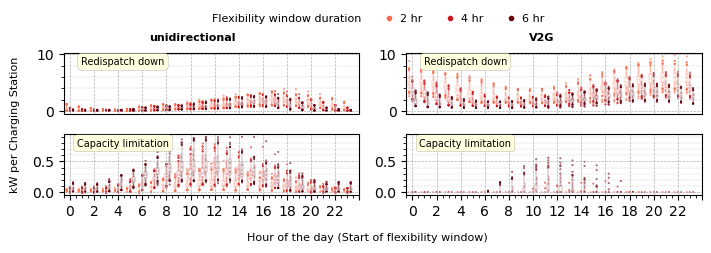

In [9]:
def generate_flexibility_plots_window_all(
    all_flex_res_path_uni, 
    all_flex_res_path_v2g,
    product_list, 
    color_palette, 
    bi_directional_list=[False,True], 
    normalize=True, 
    output_path=None
):
    # Load and preprocess data
    all_flex_res = pd.concat([pd.read_parquet(all_flex_res_path_uni), pd.read_parquet(all_flex_res_path_v2g)])
    all_flex_res.index = all_flex_res['Index'].apply(lambda x: str(x))
    result_dist = {}

    # Helper function to create boxenplot
    def create_boxenplot(df, color_palette, ax):
        unique_groups = sorted(df['window_duration'].unique())
        custom_palette = dict(zip(unique_groups, color_palette))
        sns.boxenplot(
            data=df,
            x='Hour_of_day',
            y='Values',
            hue='window_duration',
            ax=ax,
            gap=0.3,
            palette=custom_palette,
            linewidth=0.2,
            width=0.8,
            fill=False,
            flier_kws={'s': 0.5, 'marker': '.'},
            legend=False,
        )

    # Create plot
    fig, ax = plt.subplots(len(product_list), len(bi_directional_list), figsize=(7, 2), sharex=True, sharey='row')

    for ax_idx, product_ in enumerate(product_list):
        for ax_jdx, bi_directional in enumerate(bi_directional_list):
            ax_ = ax[ax_idx,ax_jdx]
            for f_s in range(24):
                result_dist[f_s] = {}
                for f_e in range(f_s + 1, min(f_s + 7, 30)):
                    idx_str = [str({
                        'lead_time': 'inf', 
                        'bi_directional': bi_directional, 
                        'f_start': f_s, 
                        'f_end': f_e, 
                        'product': product_, 
                        'base_profile': 'Dumb', 
                        'data_index': n
                    }) for n in range(363)]
                    if normalize:
                        result_dist[f_s][f'window_{int(f_e-f_s)}'] = (
                            all_flex_res.loc[idx_str]['flexibility_kW'].values / 
                            len(all_flex_res.loc[idx_str]['number_active_charging_station'].values)
                        )
                    else:
                        result_dist[f_s][f'window_{int(f_e-f_s)}'] = all_flex_res.loc[idx_str]['flexibility_kW'].values
            
            # Transform the dictionary into a DataFrame
            rows = []
            for hour_of_day, lead_times in result_dist.items():
                for lead_time, values in lead_times.items():
                    for index, value in enumerate(values):
                        rows.append({'Hour_of_day': hour_of_day, 'window_duration': lead_time, 'Index': index, 'Values': value})
            df = pd.DataFrame(rows)
            df = df[df['window_duration'].isin(['window_2', 'window_4', 'window_6'])]
            
            create_boxenplot(df, color_palette, ax_)
            
            ax_.set_ylabel('')
            ax_.set_xlabel('')
            if ax_idx == 0:
                # remove ticks
                ax_.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 

            if ax_jdx == 1:
                ax_.tick_params(axis='y', which='both', right=False, left=True, labelleft=True)


            ax_.set_xticks(list(range(0, 26, 2)))
            ax_.minorticks_on()

            ax_.grid(axis='both', linestyle='--', linewidth=0.5, which='major')
            ax_.grid(axis='y', linestyle='--', linewidth=0.2, which='minor')
            # put total of 5 grid irrespective of the number of ticks
            
            # Product-specific annotations
            product_name = 'Redispatch down' if product_ == 're_dispatch_down' else 'Capacity limitation'
            ax_.text(
                0.2, 0.85, product_name,
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax_.transAxes,
                fontsize=7,
                weight='normal',
                bbox=dict(facecolor='lightyellow', boxstyle='round,pad=0.35', linewidth=0.1)
            )

    fig.text(-0.01, 0.55, 'kW per Charging Station', va='center', rotation='vertical', fontsize=8)
    fig.text(0.25, 0.98, 'unidirectional', ha='center', va='center', fontsize=8, fontweight='bold')
    fig.text(0.75, 0.98, 'V2G', ha='center', va='center', fontsize=8, fontweight='bold')
    fig.text(0.5, -0.02, 'Hour of the day (Start of flexibility window)', ha='center', va='center', fontsize=8)

    # Custom legend
    header = [plt.Line2D([0], [0], color='w', marker='o', markerfacecolor='w', markersize=0)]
    custom_legend = [
        plt.Line2D([0], [0], color=color_palette[i], marker='o', linestyle='', markersize=3, label=f'{w} hr') 
        for i, w in enumerate(['2', '4', '6'])
    ]
    # fig.text(0.5, 1.1, 'Variation of flexibility window duration for residential CS under unoptimized BAU schedule', ha='center', va='center', fontsize=8, fontweight='bold', color='blue')
    fig.legend(header + custom_legend, 
               ["Flexibility window duration", '2 hr', '4 hr', '6 hr'], 
               loc='upper center', 
               fontsize=8, ncol=4, bbox_to_anchor=(0.5, 1.15), frameon=False, columnspacing=1.5, handletextpad=0)
    
    #arrange the space between the plots
    fig.subplots_adjust(wspace=0, hspace=0.1)
    plt.tight_layout()

    # Save plot
    if output_path:
        plt.savefig(output_path, bbox_inches='tight')
    else:
        plt.show()

# Usage example
generate_flexibility_plots_window_all(
    all_flex_res_path_uni=ROOT_PATH+'outputs/flexibility_products_results_residential_all_flex_window_unidirectional.parquet',
    all_flex_res_path_v2g=ROOT_PATH+'outputs/flexibility_products_results_residential_all_flex_window_v2g.parquet',
    product_list=['re_dispatch_down', 'capacity_limitation'],
    color_palette=['#fb6a4a', '#cb181d', '#67000d'],
    bi_directional_list=[False,True],
    normalize=True,
    output_path=ROOT_PATH + 'results/residential_uni_bi_both_directional_inf_lead_window_variation.pdf'
)




## Analysis of different lead time

## All Flex Window: Residential

### Pre-processing to convert the raw results suitable for plot

In [48]:

def plot_flexibility_lead_time_variation(all_iter_list,
    cat_list, base_profile_list, product_, lead_time_list, normalize,
    root_path,bi_directional_=False, save_plot=True
):
    """
    Plots flexibility lead time variation for given categories and base profiles.

    Parameters:
    - cat_list (list): List of categories (e.g., ['residential', 'shared', 'commercial']).
    - base_profile_list (list): List of base profiles (e.g., ['Cost', 'Dumb', 'MEF']).
    - product_ (str): Product type (e.g., 'capacity_limitation').
    - lead_time_list (list): List of lead times (e.g., ['inf', '1']).
    - normalize (bool): Whether to normalize flexibility by the number of active charging stations.
    - root_path (str): Root path for input and output files.
    - bi_directional_ (bool): Whether to consider bi-directional charging.

    Returns:
    - None
    """
    f, ax = plt.subplots(len(cat_list), len(base_profile_list), figsize=(7, 3), sharex=True, sharey='row')
    mef_mean = np.array([all_iter_list['residential'][n]['signals']['mef']['MEF']
                [24:48].to_list() for n in range(len(all_iter_list['residential']))]).mean(axis=0)

    day_ahead_mean = np.array([all_iter_list['residential'][n]['signals']['day_ahead_price']['Day-ahead Price [EUR/kWh]'][24:48].to_list() for n in range(len(all_iter_list['residential']))]).mean(axis=0)
    for i, base_profile_ in enumerate(base_profile_list):
        for j, cat_ in enumerate(cat_list):
            flex_data = pd.read_parquet(root_path + f'outputs/flexibility_products_results_{cat_}_indexed_for_plot.parquet')
            flex_data_to_consider = flex_data[
                (flex_data['product'] == product_)
                & (flex_data['base_profile'] == base_profile_)
                & (flex_data['bi_directional'] == bi_directional_)
                & flex_data['lead_time'].isin(lead_time_list)
            ].copy()

            flex_data_to_consider['flexibility_kW_norm'] = flex_data_to_consider.apply(
                lambda x: x['flexibility_kW'] / x['number_active_charging_station'], axis=1
            )
            color_palette = ['#006837', '#fdae61', '#a50026']
            unique_groups = lead_time_list
            custom_palette = dict(zip(unique_groups, color_palette))

            if normalize:
                sns.boxenplot(
                    data=flex_data_to_consider,
                    x='f_start',
                    y='flexibility_kW_norm',
                    hue='lead_time',
                    ax=ax[i, j],
                    gap=0.3,
                    palette=custom_palette,
                    linewidth=0.2,
                    width=0.8,
                    fill=False,
                    flier_kws={'s': 0.5, 'marker': '.'},
                    legend=False
                )

                mean_24_lead = flex_data_to_consider[flex_data_to_consider['lead_time'] == 'inf'].groupby('f_start')['flexibility_kW_norm'].mean()
                mean_1_lead = flex_data_to_consider[flex_data_to_consider['lead_time'] == '1'].groupby('f_start')['flexibility_kW_norm'].mean()
                # Plot the difference between the mean values
                if product_ == 'capacity_limitation':   
                    diff_ = -(mean_24_lead - mean_1_lead) 
                else:
                    diff_ = mean_24_lead - mean_1_lead

                # round the difference to 2 decimal places
                diff_ = diff_.round(2)
                # make a second y-axis
                ax_secondary = ax[i, j].twinx()
                ax_secondary.plot(np.arange(24), diff_.values,  linestyle='-', linewidth=0.5, color='#8c510a',marker='o', markersize=.8)
                ax_secondary.spines['top'].set_visible(False)
                ax_secondary.spines['right'].set_visible(False)
                ax_secondary.spines['left'].set_visible(False)
                ax_secondary.spines['bottom'].set_visible(False)
            
                ax_secondary.set_ylim([0,1.5])
                ax_secondary.set_yticks([0.1,0.5,1,1.5])

                if base_profile_ == 'Dumb':
                    ax_secondary.set_ylim([-0.1,0.1])
                    ax_secondary.set_yticks([0])

                # if base_profile_ == 'Cost':
                #     ax_secondary.step(np.arange(24), day_ahead_mean, color='black', label='Day-ahead price [EUR/kWh]', linewidth=1)
                # elif base_profile_ == 'MEF':
                #     ax_secondary.step(np.arange(24), mef_mean, color='black', label='MEF [gCO2eq/kWh]', linewidth=1)
                

                if j!=2:
                    ax_secondary.set_yticks([])
                    ax_secondary.set_yticklabels([])
            else:
                sns.boxenplot(
                    data=flex_data_to_consider,
                    x='f_start',
                    y='flexibility_kW',
                    hue='lead_time',
                    ax=ax[i, j],
                    gap=0.3,
                    palette=custom_palette,
                    linewidth=0.2,
                    width=0.8,
                    fill=False,
                    flier_kws={'s': 0.5, 'marker': '.'},
                    legend=False
                )

            ax[i, j].set_ylabel('')
            ax[i, j].set_xlabel('')
            ax[i, j].set_xticks(list(range(0, 27, 3)),labels=range(0, 27, 3), fontsize=8)
            ax[i, j].grid(axis='both', linestyle='--', linewidth=0.5)

            if i == 0:
                ax[i, j].text(
                    0.5, 1.05, cat_,
                    horizontalalignment='center',
                    verticalalignment='bottom',
                    transform=ax[i, j].transAxes,
                    fontsize=7,
                    weight='normal',
                    bbox=dict(facecolor='lightyellow', boxstyle='round,pad=0.35', linewidth=0.1)
                )
            if base_profile_ == 'Cost':
                base_profile_name = 'cost'
            elif base_profile_ == 'MEF':
                base_profile_name = 'MEF'
            elif base_profile_ == 'Dumb':
                base_profile_name = 'unopt.'
            if j == 2:
                ax_secondary.text(
                    0.955, 1, base_profile_name,
                    horizontalalignment='center',
                    verticalalignment='top',
                    transform=ax[i, j].transAxes,
                    fontsize=7,
                    weight='normal',
                    rotation=90,
                    bbox=dict(facecolor='lightyellow', boxstyle='round,pad=0.35', linewidth=0.1)
                )

            if i!=2:
                ax[i, j].tick_params(axis='x', bottom=False)
                ax_secondary.tick_params(axis='x', bottom=False)
            if j!=0:
                ax[i, j].tick_params(axis='y', left=False, right=False)
            if j != 2:
                ax_secondary.tick_params(axis='y', left=False, right=False)
            if j == 2:
                ax_secondary.tick_params(axis='y', which='both', labelcolor='#8c510a', colors='#8c510a')
                # # Ensure integer tick labels
                # ax_secondary.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
                # ax_secondary.yaxis.offsetText.set_visible(False)

                



    # Reduce space between subplots
    plt.subplots_adjust(wspace=0.05, hspace=0.1)

    # Add labels to the figure
    f.text(0.5, 0, 'Hour of the day (Start of flexibility window)', ha='center', va='center', fontsize=8)
    if product_ == 're_dispatch_down':
        y_label ='Redispatch (kW/CS)'
    elif product_ == 'capacity_limitation':
        y_label = 'Required capacity (kW/CS)'
    f.text(0.06, 0.5, y_label, va='center', rotation='vertical', fontsize=8)
    f.text(0.98, 0.5, 'Average reduction in flexibility ('+r'$\Delta \mathrm{kW}$'+'/ CS'+')', ha='center', va='center', fontsize=8,rotation='vertical', color='#8c510a')

    # Add legend
    header = [plt.Line2D([0], [0], color='w', marker='o', markerfacecolor='w', markersize=0)]
    custom_legend = [
        plt.Line2D([0], [0], color=color_palette[i], marker='o', linestyle='', markersize=3, label=f'{w} hr')
        for i, w in enumerate(lead_time_list)
    ]
    f.legend(
        header + custom_legend,
        ["Lead time:", '>24 hour', '1 hour'],
        loc='upper center',
        fontsize=8, ncol=4, bbox_to_anchor=(0.5, 1.03), frameon=False, columnspacing=1.5, handletextpad=0
    )
    if product_ == 're_dispatch_down':
        product_name = 'redispatch'
    elif product_ == 'capacity_limitation':
        product_name = 'capacity limitation'
    # f.text(0.5, 1.05, f'Variation in lead time for {product_name} with unidirectional charging', ha='center', va='center', fontsize=8, fontweight='bold', color='blue')

    # Save plot
    if save_plot:
        plt.savefig(root_path+f'/results/flexibility_lead_time_variation_{product_}.pdf', bbox_inches='tight')
        plt.savefig(root_path+f'/results/flexibility_lead_time_variation_{product_}.png',dpi=1200, bbox_inches='tight')

def plot_flexibility_lead_time_variation_bi_true(
    cat_list,base_profile_, product_list, lead_time_list, normalize,
    root_path, save_plot=True
):
    """
    Plots flexibility lead time variation for given categories and base profiles.

    Parameters:
    - cat_list (list): List of categories (e.g., ['residential', 'shared', 'commercial']).
    - base_profile_list (list): List of base profiles (e.g., ['Cost', 'Dumb', 'MEF']).
    - product_ (str): Product type (e.g., 'capacity_limitation').
    - lead_time_list (list): List of lead times (e.g., ['inf', '1']).
    - normalize (bool): Whether to normalize flexibility by the number of active charging stations.
    - root_path (str): Root path for input and output files.
    - bi_directional_ (bool): Whether to consider bi-directional charging.

    Returns:
    - None
    """
    f, ax = plt.subplots(len(product_list), len(cat_list), figsize=(7, 1.2), sharex=True, sharey='row')
    plt.rcParams.update({'font.size': 8})
    for i, product_ in enumerate(product_list):
        
        for j, cat_ in enumerate(cat_list):
            flex_data = pd.read_parquet(root_path + f'outputs/flexibility_products_results_{cat_}_indexed_for_plot.parquet')
            flex_data_to_consider = flex_data[
                (flex_data['product'] == product_)
                & (flex_data['base_profile'] == base_profile_)
                & (flex_data['bi_directional'] == True)
                & flex_data['lead_time'].isin(lead_time_list)
            ].copy()

            flex_data_to_consider['flexibility_kW_norm'] = flex_data_to_consider.apply(
                lambda x: x['flexibility_kW'] / x['number_active_charging_station'], axis=1
            )
            color_palette = ['#006837', '#fdae61', '#a50026']
            unique_groups = lead_time_list
            custom_palette = dict(zip(unique_groups, color_palette))
            try:
                ax_current = ax[i, j]
            except:
                ax_current = ax[j]

            if normalize:
                sns.boxenplot(
                    data=flex_data_to_consider,
                    x='f_start',
                    y='flexibility_kW_norm',
                    hue='lead_time',
                    ax=ax_current,
                    gap=0.3,
                    palette=custom_palette,
                    linewidth=0.2,
                    width=0.8,
                    fill=False,
                    flier_kws={'s': 0.5, 'marker': '.'},
                    legend=False
                )
                mean_24_lead = flex_data_to_consider[flex_data_to_consider['lead_time'] == 'inf'].groupby('f_start')['flexibility_kW_norm'].mean()
                mean_1_lead = flex_data_to_consider[flex_data_to_consider['lead_time'] == '1'].groupby('f_start')['flexibility_kW_norm'].mean()
                # Plot the difference between the mean values
                if product_ == 'capacity_limitation':   
                    diff_ = -(mean_24_lead - mean_1_lead) 
                else:
                    diff_ = mean_24_lead - mean_1_lead

               
                # round the difference to 2 decimal places
                diff_ = diff_.round(2)
                print(diff_)
                # make a second y-axis
                ax_secondary = ax_current.twinx()
                ax_secondary.plot(np.arange(24), diff_.values,  linestyle='-', linewidth=0.5, color='#8c510a',marker='o', markersize=.8)
                ax_secondary.spines['top'].set_visible(False)
                ax_secondary.spines['right'].set_visible(False)
                ax_secondary.spines['left'].set_visible(False)
                ax_secondary.spines['bottom'].set_visible(False)
                ax_secondary.set_ylim([0,1.6])
                ax_secondary.set_yticks([0,0.5,1,1.5])
                
                
                if j!=2:
                    ax_secondary.set_yticks([])
                    ax_secondary.set_yticklabels([])
            else:
                sns.boxenplot(
                    data=flex_data_to_consider,
                    x='f_start',
                    y='flexibility_kW',
                    hue='lead_time',
                    ax=ax_current,
                    gap=0.3,
                    palette=custom_palette,
                    linewidth=0.2,
                    width=0.8,
                    fill=False,
                    flier_kws={'s': 0.5, 'marker': '.'},
                    legend=False
                )

            ax_current.set_ylabel('')
            ax_current.set_xlabel('')
            ax_current.set_xticks(list(range(0, 27, 3)),labels=range(0, 27, 3), fontsize=8)
            ax_current.grid(axis='both', linestyle='--', linewidth=0.5)

            if i == 0:
                ax_current.text(
                    0.5, 1.05, cat_,
                    horizontalalignment='center',
                    verticalalignment='bottom',
                    transform=ax_current.transAxes,
                    fontsize=7,
                    weight='normal',
                    bbox=dict(facecolor='lightyellow', boxstyle='round,pad=0.35', linewidth=0.1)
                )
            if product_ == 're_dispatch_down':
                product_name = 'redispatch'
            elif product_ == 'capacity_limitation':
                product_name = 'capacity lim.'
            # if j == 2:
            #     ax_secondary.text(
            #         0.955, 1, product_name,
            #         horizontalalignment='center',
            #         verticalalignment='top',
            #         transform=ax_current.transAxes,
            #         fontsize=7,
            #         weight='normal',
            #         rotation=90,
            #         bbox=dict(facecolor='lightyellow', boxstyle='round,pad=0.35', linewidth=0.1)
            #     )


            if i!=1:
                ax_current.tick_params(axis='x', bottom=False)
                ax_secondary.tick_params(axis='x', bottom=False)
            if j!=0:
                ax_current.tick_params(axis='y', left=False, right=False)
            if j != 2:
                ax_secondary.tick_params(axis='y', left=False, right=False)
            if j == 2:
                ax_secondary.tick_params(axis='y', which='both', labelcolor='#8c510a', colors='#8c510a')
          

    # Reduce space between subplots
    plt.subplots_adjust(wspace=0.05, hspace=0.1)

    # Add labels to the figure
    f.text(0.5, -0.15, 'Hour of the day (Start of flexibility window)', ha='center', va='center', fontsize=8, )
    f.text(0.06, 0.5, 'Redispatch (kW/ CS)', va='center', rotation='vertical', fontsize=8)
    f.text(0.96, 0.5, 'Average reduction in \n flexibility  ('+r'$\Delta \mathrm{kW}$'+'/ CS'+')', ha='center', va='center', fontsize=8, rotation='vertical', color='#8c510a')

    # Add legend
    header = [plt.Line2D([0], [0], color='w', marker='o', markerfacecolor='w', markersize=0)]
    custom_legend = [
        plt.Line2D([0], [0], color=color_palette[i], marker='o', linestyle='', markersize=3, label=f'{w} hr')
        for i, w in enumerate(lead_time_list)
    ]
    f.legend(
        header + custom_legend,
        ["Lead time:", '>24 hour', '1 hour'],
        loc='upper center',
        fontsize=8, ncol=4, bbox_to_anchor=(0.5, 1.26), frameon=False, columnspacing=1.5, handletextpad=0
    )
    # f.text(0.5, 1.1, 'Variation in lead time using V2G with a cost minimized BAU schedule', ha='center', va='center', fontsize=8, fontweight='bold', color='blue')
    # fontsize to 8
    # reset rcparam font size
    
#     # Save plot
    if save_plot:
        plt.savefig(root_path+f'/results/flexibility_lead_time_variation_{product_}_bi.pdf', bbox_inches='tight')



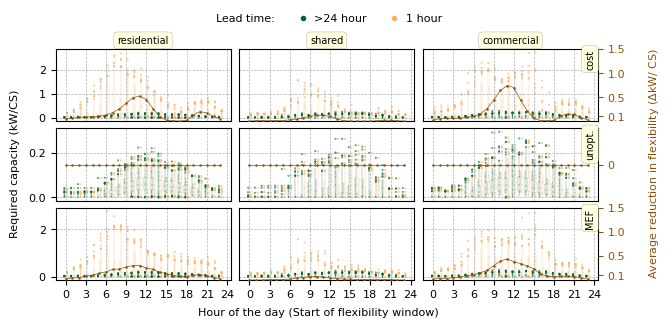

In [49]:
plot_flexibility_lead_time_variation(all_iter_list,
    cat_list=['residential', 'shared', 'commercial'],
    base_profile_list=['Cost', 'Dumb', 'MEF'],
    product_='capacity_limitation',
    lead_time_list=['inf', '1'],
    normalize=True,
    root_path=ROOT_PATH
)


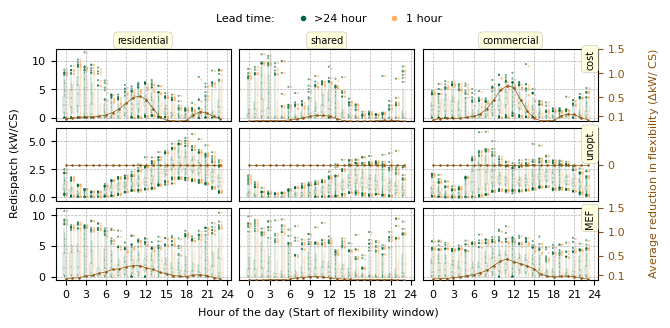

In [50]:
plot_flexibility_lead_time_variation(all_iter_list,
    cat_list=['residential', 'shared', 'commercial'],
    base_profile_list=['Cost', 'Dumb', 'MEF'],
    product_='re_dispatch_down',
    lead_time_list=['inf', '1'],
    normalize=True,
    root_path=ROOT_PATH
)

f_start
0     0.16
1     0.23
2     0.32
3     0.36
4     0.33
5     0.31
6     0.34
7     0.43
8     0.58
9     0.79
10    0.95
11    0.98
12    0.85
13    0.50
14    0.18
15    0.04
16    0.01
17    0.01
18    0.08
19    0.25
20    0.33
21    0.26
22    0.17
23    0.13
Name: flexibility_kW_norm, dtype: float64
f_start
0     0.01
1     0.02
2     0.03
3     0.03
4     0.03
5     0.05
6     0.08
7     0.12
8     0.16
9     0.22
10    0.24
11    0.23
12    0.18
13    0.08
14    0.02
15    0.01
16    0.00
17    0.00
18    0.01
19    0.02
20    0.03
21    0.02
22    0.01
23    0.01
Name: flexibility_kW_norm, dtype: float64
f_start
0     0.12
1     0.17
2     0.22
3     0.24
4     0.23
5     0.23
6     0.26
7     0.36
8     0.58
9     0.94
10    1.31
11    1.52
12    1.45
13    0.97
14    0.41
15    0.11
16    0.02
17    0.01
18    0.07
19    0.20
20    0.25
21    0.20
22    0.11
23    0.09
Name: flexibility_kW_norm, dtype: float64


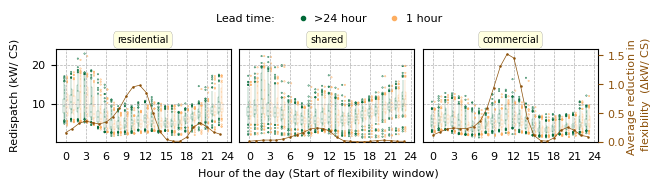

In [41]:
plot_flexibility_lead_time_variation_bi_true(cat_list=['residential','shared','commercial'],base_profile_='Cost', product_list=['re_dispatch_down',], 
                                             lead_time_list=['inf','1'], normalize=True, root_path=ROOT_PATH, save_plot=True)


### Cost and MEF analysis

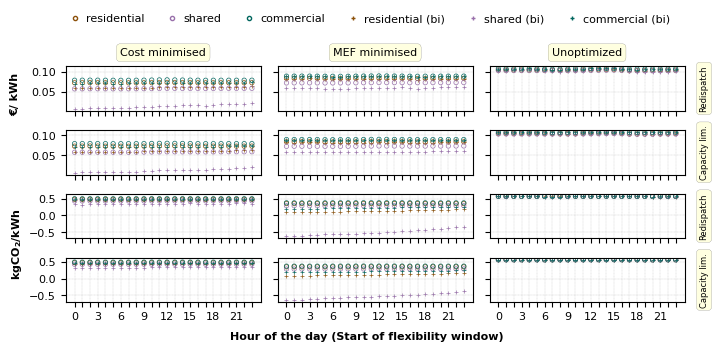

In [42]:

base_profile_list = ['Cost','MEF','Dumb']
cat_list = ['residential', 'shared', 'commercial']
root_path =ROOT_PATH
category_colors = ['#8c510a', '#9970ab', '#01665e']
avg_cost ={}
avg_mef = {}


for bi_directional_ in bi_directional_list:
    for cat_ in cat_list:
        flex_data = pd.read_parquet(ROOT_PATH+f'outputs/flexibility_products_results_{cat_}_indexed_for_plot.parquet')
        flex_data['Energy_charged'] = flex_data['base_aggregate_profile_kW'].apply(lambda x: sum(np.array(x)))
        for product_ in product_list:
            for base_profile_ in base_profile_list:
                f_consider = flex_data[(flex_data['product'] == product_) & (flex_data['base_profile'] == base_profile_) & (flex_data['bi_directional'] == bi_directional_)].copy()
                avg_cost[(product_,base_profile_,cat_, bi_directional_)] = []
                avg_mef[(product_,base_profile_, cat_, bi_directional_)] = []
                for f_start in range(24):
                    f_consider_ = f_consider[f_consider['f_start'] == f_start].copy()
                    avg_cost[(product_,base_profile_,cat_,bi_directional_)].append(f_consider_['charging_cost_EUR'].mean()/f_consider_['Energy_charged'].mean())
                    avg_mef[(product_,base_profile_, cat_,bi_directional_)].append(f_consider_['charging_emission_kgCO2'].mean()/f_consider_['Energy_charged'].mean())


# Set up the subplot grid
fig, axes = plt.subplots(nrows=len(product_list)*2, ncols=len(base_profile_list), figsize=(7, 3), sharex=True, sharey='row')


df=pd.DataFrame(avg_cost)
x_ticks = np.arange(len(df.index))  # Time steps for x-axis
# Loop through products and base profiles to create subplots
for i, product in enumerate(product_list):  # Rows
    for j, base_profile in enumerate(base_profile_list):  # Columns
        ax = axes[i, j]
        
        # Loop through categories
        for k, (category, color) in enumerate(zip(cat_list, category_colors)):
            # Scatter for Bi-directional True
            y_true = df[(product, base_profile, category, True)]
            ax.scatter(
                x_ticks, y_true, label=f"{category} (True)", marker='+',color=color, s=10, linewidth=0.5

            )
            # Scatter for Bi-directional False
            y_false = df[(product, base_profile, category, False)]
            ax.scatter(
                x_ticks, y_false, label=f"{category} (False)", marker='o',facecolor='none', edgecolor=color, alpha=1, s=10, linewidth=0.5
            )
        #Text box for base profile
        if base_profile == 'Cost':
            base_profile_name = 'Cost minimised'
        elif base_profile == 'MEF':
            base_profile_name = 'MEF minimised'
        elif base_profile == 'Dumb':
            base_profile_name = 'Unoptimized'
        if i == 0:
            ax.text(
                0.5, 1.3, base_profile_name,
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax.transAxes,
                fontsize=8,
                weight='normal',
                bbox=dict(facecolor='lightyellow', boxstyle='round,pad=0.35', linewidth=0.1)
            )
        if product == 're_dispatch_down':
            product_name = 'Redispatch'
        elif product == 'capacity_limitation':
            product_name = 'Capacity lim.'
        if j == 2:
            ax.text(
                1.1, 0.5, product_name,
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax.transAxes,
                fontsize=6,
                weight='normal',
                rotation=90,
                bbox=dict(facecolor='lightyellow', boxstyle='round,pad=0.35', linewidth=0.1)
            )
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(df.index)
        ax.set_xticks(np.arange(0, 24, 1))
        # only label for every 3rd tick
        ax.set_xticklabels([0,'','',3,'','',6,'','',9,'','',12,'','',15,'','',18,'','',21,'',''], fontsize=8)


        ax.grid(axis='both', linestyle='--', linewidth=0.2) 


        plt.rcParams.update({'font.size': 8})


df=pd.DataFrame(avg_mef)
x_ticks = np.arange(len(df.index))  # Time steps for x-axis
for i, product in enumerate(product_list):  # Rows
    for j, base_profile in enumerate(base_profile_list):  # Columns
        ax = axes[2+i, j]
        
        # Loop through categories
        for k, (category, color) in enumerate(zip(cat_list, category_colors)):
            # Scatter for Bi-directional True
            y_true = df[(product, base_profile, category, True)]
            ax.scatter(
                x_ticks, y_true, label=f"{category} (True)", marker='+',color=color, s=10, linewidth=0.5

            )
            # Scatter for Bi-directional False
            y_false = df[(product, base_profile, category, False)]
            ax.scatter(
                x_ticks, y_false, label=f"{category} (False)", marker='o',facecolor='none', edgecolor=color, alpha=1, s=10, linewidth=0.5
            )
        if product == 're_dispatch_down':
            product_name = 'Redispatch'
        elif product == 'capacity_limitation':
            product_name = 'Capacity lim.'
        if j == 2:
            ax.text(
                1.1, 0.5, product_name,
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax.transAxes,
                fontsize=6,
                weight='normal',
                rotation=90,
                bbox=dict(facecolor='lightyellow', boxstyle='round,pad=0.35', linewidth=0.1)
            )
        # Customize subplot

        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(df.index)
        ax.set_xticks(np.arange(0, 24, 1))
        # only label for every 3rd tick
        ax.set_xticklabels([0,'','',3,'','',6,'','',9,'','',12,'','',15,'','',18,'','',21,'',''], fontsize=8)


        ax.grid(axis='both', linestyle='--', linewidth=0.2) 


        plt.rcParams.update({'font.size': 8})

# xlabel and ylabel for figure
fig.text(0.5, -0.01, 'Hour of the day (Start of flexibility window)', ha='center', va='center', fontsize=8, fontweight='bold')
fig.text(-0.01, 0.8, '€/ kWh', va='center', rotation='vertical', fontsize=8, fontweight='bold')
fig.text(-0.01, 0.3, '$\mathbf{kgCO_2/ kWh}$', va='center', rotation='vertical', fontsize=8, fontweight='bold')
    
#Legend
custom_legend = [
    plt.Line2D([0], [0], color=category_colors[i], marker='o', linestyle='', markersize=3, markerfacecolor='none') for i in range(3)
] +[
    plt.Line2D([0], [0], color=category_colors[i], marker='+', linestyle='', markersize=3, markerfacecolor='none') for i in range(3)
]
fig.legend(custom_legend, ['residential','shared','commercial','residential (bi)','shared (bi)','commercial (bi)'], loc='upper center', fontsize=8, ncol=6, bbox_to_anchor=(0.5, 1.1), frameon=False, columnspacing=1.5, handletextpad=0)
# Adjust layout and show plot
plt.tight_layout()
plt.savefig(root_path+'/results/average_cost_mef_variation.pdf', bbox_inches='tight')

## COST and MEF averaged peer day

In [14]:
def calculat_base_costs(all_iter_list,bi_directional_list=[False, True],base_profile_list = ['Cost','MEF','Dumb'],
                                    cat_list = ['residential', 'shared', 'commercial'],
                                    root_path =ROOT_PATH):
    """ Calculate the average cost for each base profile and category
    parameters:
    all_iter_list: dict
    root_path: str
    Returns:
    df_base_cost_grouped: pd.DataFrame
    df_base_mef_grouped: pd.DataFrame
    """
    
    avg_cost =[]
    avg_mef = []
    for bi_directional_ in bi_directional_list:
        for cat_ in cat_list:
            for base_profile_ in base_profile_list:
                # defining opt_str
                if bi_directional_:
                    if base_profile_ == 'Cost':
                        opt_str = 'profile_Cost_bi_directional_True'
                    elif base_profile_ == 'MEF':
                        opt_str = 'profile_MEF_bi_directional_True'
                    elif base_profile_ == 'Dumb':
                        opt_str = 'profile_Dumb_bi_directional_False'
                else:
                    if base_profile_ == 'Cost':
                        opt_str = 'profile_Cost_bi_directional_False'
                    elif base_profile_ == 'MEF':
                        opt_str = 'profile_MEF_bi_directional_False'
                    elif base_profile_ == 'Dumb':
                        opt_str = 'profile_Dumb_bi_directional_False'

                if bi_directional_:
                    bi_dir_tag = 'V2G'
                else:
                    bi_dir_tag = 'unidirectional'

                value_cost = [sum(all_iter_list[cat_][n]['aggeregate_profiles'][opt_str]*all_iter_list[cat_][n]['signals']['day_ahead_price']['Day-ahead Price [EUR/kWh]'])/all_iter_list[cat_][n]['individual_data']['VOL'].sum() for n in range(363)]
                
                value_mef = [sum(all_iter_list[cat_][n]['aggeregate_profiles'][opt_str]*all_iter_list[cat_][n]['signals']['mef']['MEF'])/all_iter_list[cat_][n]['individual_data']['VOL'].sum() for n in range(363)]
                avg_cost += [{'value': np.mean(value_cost), 'category': cat_, 'product':'None','base_profile':base_profile_,
                            'charging_strategy': bi_dir_tag}]
                avg_mef += [{'value': np.mean(value_mef), 'category': cat_, 'product':'None','base_profile':base_profile_,
                            'charging_strategy': bi_dir_tag}]
            
    base_avg_cost = pd.DataFrame(avg_cost)
    base_avg_mef = pd.DataFrame(avg_mef)
    return base_avg_cost, base_avg_mef

def create_cost_mef_optimized_group(all_iter_list,base_profile_list = ['Cost','MEF','Dumb'],
                                    product_list = ['re_dispatch_down','capacity_limitation'],
                                    cat_list = ['residential', 'shared', 'commercial'],
                                    root_path =ROOT_PATH):
    """ Calculate the average cost for each base profile and category
    parameters:
    base_profile_list: list
    product_list: list
    cat_list: list
    root_path: str
    Returns:
    df_optimized_cost_grouped: pd.DataFrame
    df_optimized_mef_grouped: pd.DataFrame
    """
    avg_cost =[]
    avg_mef = []
    for bi_directional_ in bi_directional_list:
        for cat_ in cat_list:
            flex_data = pd.read_parquet(ROOT_PATH+f'outputs/flexibility_products_results_{cat_}_indexed_for_plot.parquet').reset_index()
            flex_data['data_index'] = flex_data.apply(lambda x: ast.literal_eval(x['index'])['data_index'], axis=1)
            # flex_data['Energy_charged'] = flex_data.apply(lambda x: all_iter_list['residential'][x['data_index']]['individual_data']['VOL'].sum(), axis=1)
            flex_data['Energy_charged'] = flex_data.apply(lambda x:np.sum(x['optimized_aggregate_profile_kW']), axis=1)
            for product_ in product_list:
                for base_profile_ in base_profile_list:
                    if bi_directional_:
                        bi_dir_tag = 'V2G'
                    else:
                        bi_dir_tag = 'unidirectional'
                    f_consider = flex_data[(flex_data['product'] == product_) & (flex_data['base_profile'] == base_profile_) & (flex_data['bi_directional'] == bi_directional_)&(flex_data['lead_time']=='inf')].copy()
                    f_consider['charging_cost_EUR_per_kWh'] = f_consider.apply(lambda x: x['charging_cost_EUR']/x['Energy_charged'], axis=1)
                    f_consider['charging_emission_kgCO2_per_kWh'] = f_consider.apply(lambda x: x['charging_emission_kgCO2']/x['Energy_charged'], axis=1)
                    avg_cost += [{'value': f_consider['charging_cost_EUR_per_kWh'].mean(), 'category': cat_, 'product':product_,'base_profile':base_profile_,
                                'charging_strategy': bi_dir_tag}]
                    avg_mef += [{'value': f_consider['charging_emission_kgCO2_per_kWh'].mean(), 'category': cat_, 'product':product_,'base_profile':base_profile_,
                                'charging_strategy': bi_dir_tag}]
    df_optimized_cost = pd.DataFrame(avg_cost)
    df_optimized_mef = pd.DataFrame(avg_mef)

    #save the results
    df_optimized_cost.to_csv(root_path+'/results/df_optimized_cost_grouped.csv')
    df_optimized_mef.to_csv(root_path+'/results/df_optimized_mef_grouped.csv')
    return df_optimized_cost, df_optimized_mef


In [15]:
df_opt_cost, df_opt_mef= create_cost_mef_optimized_group(all_iter_list)
df_base_cost, df_base_mef = calculat_base_costs(all_iter_list) 

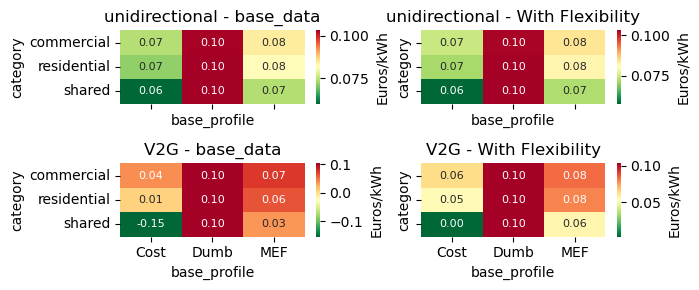

In [18]:
strategy= ['unidirectional', 'V2G']
product = 'capacity_limitation'

data_list = {'base_data': df_base_cost, 'With Flexibility': df_opt_cost}
df_to_plot = df_opt_cost.copy()


f, ax = plt.subplots(2,2, figsize=(7, 3), sharex=True, sharey=True)


for i, strategy in enumerate(strategy):
    j = 0
    for keys, data in data_list.items():
        ax_to_plot = ax[i,j]
        if keys=='base_data':
            heat_map_data=data[(data['charging_strategy']==strategy)].pivot(index='category', columns='base_profile', values='value')
        else:
            heat_map_data=data[(data['charging_strategy']==strategy) &
                       (data['product']==product)].pivot(index='category', columns='base_profile', values='value')
    
        sns.heatmap(
                    data=heat_map_data,
                    cmap='RdYlGn_r', 
                    annot=True,
                    fmt=".2f",
                    cbar_kws={'label': r'Euros/kWh'},  # Use the same color scale for the second heatmap
                    annot_kws={"size": 8},ax=ax_to_plot)


        ax_to_plot.set_title(f'{strategy} - {keys}')


        j += 1

plt.tight_layout()

        


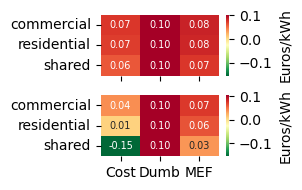

In [21]:
strategy = ['unidirectional', 'V2G']
product = 'capacity_limitation'

data_list = {'base_data': df_base_cost}  # , 'With flexibility': df_opt_mef}
df_to_plot = df_opt_cost.copy()

f, ax = plt.subplots(2, 1, figsize=(3, 2), sharex=True, sharey=True)

# Determine the min and max values for the color map
vmin = min(df_base_cost['value'].min(), df_opt_cost['value'].min())
vmax = max(df_base_cost['value'].max(), df_opt_cost['value'].max())

for i, strategy in enumerate(strategy):
    for keys, data in data_list.items():
        ax_to_plot = ax[i]
        if keys == 'base_data':
            heat_map_data = data[(data['charging_strategy'] == strategy)].pivot(index='category', columns='base_profile', values='value')
        else:
            heat_map_data = data[(data['charging_strategy'] == strategy) &
                                 (data['product'] == product)].pivot(index='category', columns='base_profile', values='value')

        sns.heatmap(
            data=heat_map_data,
            cmap='RdYlGn_r',
            annot=True,
            fmt=".2f",
            cbar_kws={'label': r'Euros/kWh'},
            annot_kws={"size": 7},
            ax=ax_to_plot,
            vmin=vmin,
            vmax=vmax
        )

        # remove y label
        ax_to_plot.set_ylabel('')
        ax_to_plot.set_xlabel('')

plt.tight_layout()
plt.savefig(ROOT_PATH + '/results/average_cost_base_heatmap', bbox_inches='tight', dpi=1200)


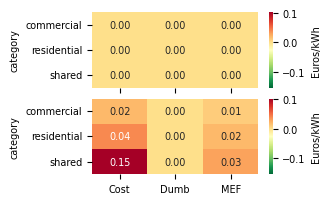

In [26]:
strategy= ['unidirectional', 'V2G']
product = 'capacity_limitation'

df_opt_cost['value_diff'] = df_opt_cost.apply(lambda x: np.round(x['value'],2) - np.round(df_base_cost[(df_base_cost['charging_strategy']==x['charging_strategy']) & 
                                                                           (df_base_cost['category']==x['category']) & 
                                                                           (df_base_cost['base_profile']==x['base_profile'])]['value'].values[0],2), axis=1)
df_opt_mef['value_diff'] = df_opt_mef.apply(lambda x: np.round(x['value'],2) - np.round(df_base_mef[(df_base_mef['charging_strategy']==x['charging_strategy']) &
                                                                            (df_base_mef['category']==x['category']) &
                                                                            (df_base_mef['base_profile']==x['base_profile'])]['value'].values[0],2), axis=1)

# Determine the min and max values for the color map
vmin = min(df_base_cost['value'].min(), df_opt_cost['value'].min())
vmax = max(df_base_cost['value'].max(), df_opt_cost['value'].max())

data_list = {'Energy Cost': df_opt_cost}#, 'Emission': df_opt_mef}
df_to_plot = df_opt_cost.copy()


f, ax = plt.subplots(2,1, figsize=(3.2,2), sharex=True, sharey=True)


for i, strategy in enumerate(strategy):

    for keys, data in data_list.items():
        ax_to_plot = ax[i]

        heat_map_data=data[(data['charging_strategy']==strategy) &
                       (data['product']==product)].pivot(index='category', columns='base_profile', values='value_diff')
    
        sns.heatmap(
                    data=heat_map_data,
                    cmap='RdYlGn_r', 
                    annot=True,
                    fmt=".2f",
                    cbar_kws={'label': r'Euros/kWh'},  # Use the same color scale for the second heatmap
                    annot_kws={"size": 7},ax=ax_to_plot,
                    vmax=vmax,
                    vmin=vmin)

        # remove x-axis label
        ax_to_plot.set_xlabel('')


        j += 1
plt.rcParams.update({'font.size': 5})
plt.tight_layout()
# save the plot
plt.savefig(ROOT_PATH+'/results/diff_cost.png', bbox_inches='tight', dpi=1200)

        
